In [ ]:
from filterpy.kalman import KalmanFilter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
kf = KalmanFilter (dim_x=9, dim_z=9)

accel_data = pd.read_csv("data/1-baseline_accel.csv")
orientation_data = pd.read_csv("data/1-baseline_orientations.csv")
wrench_data = pd.read_csv("data/1-baseline_wrench.csv")

fb = [9.07633, -1.01814, 9.98482]
tb = [0.432449, -0.692162, -0.156746]

def normalize(accel, orientation, wrench):
    first_step = np.min([accel['t'][0],orientation['t'][0],wrench['t'][0]])
    accel['t'] -=first_step
    accel['ax'] *= 9.81
    accel['ay'] *= 9.81
    accel['az'] *= 9.81
    
    wrench['fx'] -= fb[0]
    wrench['fy'] -= fb[1]
    wrench['fz'] -= fb[2]
    
    wrench['tx'] -= tb[0]
    wrench['ty'] -= tb[1]
    wrench['tz'] -= tb[2]
    
    orientation['t']-=first_step
    wrench['t']-=first_step

def skew(vec):
    return np.array([[0, -vec[2][0], vec[1][0]],[vec[2][0],0,-vec[0][0]],[-vec[1][0],vec[0][0],0]])

normalize(accel_data,orientation_data,wrench_data)

time_steps = sorted(accel_data['t'].to_list()+orientation_data['t'].to_list()+wrench_data['t'].to_list())
dt_steps = sorted(accel_data['t'].to_list()+wrench_data['t'].to_list())
m_hat = 0.932
rs_hat = np.array([[0],[0],[0.044]])

sigma_f = np.array([0.001236, 0.000444, 0.0056336])
sigma_t = np.array([1.36e-06, 3.50e-06, 6.00e-08])
sigma_a = np.array([0.004193, 0.001387, 0.009815])

R_fa = np.array([[0,0,-1],[-1,0,0],[0,1,0]])

sf = 250
st = 5000
sa = 100

sigma_k = 0.5

ff = 698.3
fr = 100.2
fa = 254.3

A = np.identity(9)

B = np.block([[np.identity(3)],[m_hat*np.identity(3)],[m_hat*skew(rs_hat)]])

R_f = np.block([[np.diag(sf*sigma_f), np.zeros((3,3))],
                [np.zeros((3,3)), np.diag(st*sigma_t)]])

R_a = np.diag(sa*sigma_a)

Q_k = np.block([[np.identity(3),np.zeros((3,3)),np.zeros((3,3))],
                [np.zeros((3,3)),m_hat*np.identity(3),np.zeros((3,3))],
                [np.zeros((3,3)),np.zeros((3,3)),m_hat*np.linalg.norm(rs_hat)*np.identity(3)]])

H_f = np.block([[np.zeros((3,3)),np.identity(3), np.zeros((3,3))],[np.zeros((3,3)),np.zeros((3,3)),np.identity(3)]])

H_a = np.block([np.identity(3),np.zeros((3,3)),np.zeros((3,3))])

g_w = np.array([0,0,-9.81])
g_s = 0
prev_g_s = 0

#print("A\n",A)
#print("-------------")
#print("B\n",B)
#print("-------------")
#print("R_f\n",R_f)
#print("-------------")
#print("Q_k\n",Q_k)
#print("-------------")
#print("H_f\n",H_f)
#print("-------------")
#print("H_a\n",H_a)
#print("-------------")
#print("R_a\n",R_a)
#print("-------------")
#print("R_f\n",R_f*sf)
#print("-------------")

x = np.zeros((9,1))

kf.F = A
kf.B = B
kf.x = x
kf.P = np.zeros((9,9))
kf.H = H_a

out = []

first = False

total_time = 0

for i,t in enumerate(time_steps):
    
    if t in orientation_data['t'].values:
        row = orientation_data.loc[orientation_data['t'] == t]
        
        r11 = row['r11'].values[0]
        r12 = row['r12'].values[0]
        r13 = row['r13'].values[0]
        r21 = row['r21'].values[0]
        r22 = row['r22'].values[0]
        r23 = row['r23'].values[0]
        r31 = row['r31'].values[0]
        r32 = row['r32'].values[0]
        r33 = row['r33'].values[0]
        
        R_k = np.array([[r11, r12, r13],
                        [r21, r22, r23],
                        [r31, r32, r33]])
        
        g_s = R_k.dot(g_w)
        u_k = (g_s-prev_g_s)*(fr/(ff+fa))
        prev_g_s = g_s
    
    if t in accel_data['t'].values:
        if i < len(dt_steps)-1:
            dt = (dt_steps[i+1]-dt_steps[i])/(10**6)
            total_time+=dt
        kf.Q = dt*Q_k*sigma_k
        
        row = accel_data.loc[accel_data['t'] == t]
        ax = row['ax'].values[0]
        ay = row['ay'].values[0]
        az = row['az'].values[0]
        ac = np.array([[ax],[ay],[az]])
        rotatoed_a = R_fa*ac

        z_a = np.array([rotatoed_a[0][0], rotatoed_a[1][0], rotatoed_a[2][0]])
        kf.H = H_a
        kf.R = R_a
        kf.dim_z = 3
        kf.predict(u=u_k)
        kf.update(z_a)
        out.append(kf.x)
    
    if t in wrench_data['t'].values:
        if i < len(dt_steps)-1:
            dt = (dt_steps[i+1]-dt_steps[i])/(10**6)
            total_time+=dt
        kf.Q = dt*Q_k*sigma_k
        
        
        row = wrench_data.loc[wrench_data['t'] == t]
        fx = row['fx'].values[0]
        fy = row['fy'].values[0]
        fz = row['fz'].values[0]
        tx = row['tx'].values[0]
        ty = row['ty'].values[0]
        tz = row['tz'].values[0]
        
        z_f = np.array([[fx], [fy], [fz], [tx], [ty], [tz]])
        kf.H = H_f
        kf.R = R_f
        kf.dim_z = 6
        kf.predict(u=u_k)
        kf.update(z_f)
        out.append(kf.x)

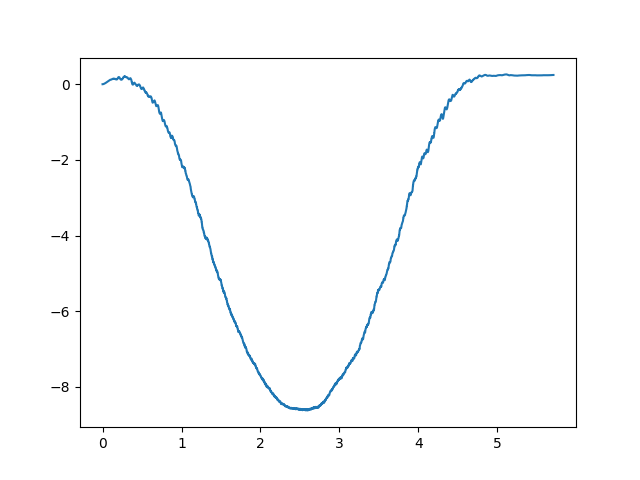

In [171]:
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
x6 = []
x7 = []
x8 = []
x9 = []
for vec in out:
    x1.append(vec[0][0])
    x2.append(vec[1][0])
    x3.append(vec[2][0])
    x4.append(vec[3][0])
    x5.append(vec[4][0])
    x6.append(vec[5][0])
    x7.append(vec[6][0])
    x8.append(vec[7][0])
    x9.append(vec[8][0])

time = np.linspace(0, total_time, len(x6))
plt.close(1); plt.figure(1)
plt.plot(time,x6)